# ПРОЕКТ-6: СЕГМЕНТАЦИЯ КЛИЕНТОВ

## 1. Постановка задачи


В данном проекте мы решаем бизнес-задачу в области маркетинга. Нам предстоит произвести сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определить оптимальную стратегию взаимодействия с ними.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать модель на новых клиентах.

## 2. Знакомство с данными. 

In [1]:
# импортируем необходимые библиотеки
import warnings 
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble

from IPython.display import display, HTML

plt.rcParams["patch.force_edgecolor"] = True

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


Для начала давайте познакомимся с нашими данными:

In [2]:
data = pd.read_csv(
    "customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print("Data shape:", data.shape)
display(data.head(5))

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы.


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


Посчитаем количество пропусков в признаках.

In [4]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Судя по описанию задачи, нам должны были предоставить данные за годовой период — проверим, так ли это.

In [5]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print("Data period:", data['InvoiceDate'].dt.date.min(), "to", data['InvoiceDate'].dt.date.max())

Data period: 2010-12-01 to 2011-12-09


Посмотрим на основные описательные статистики, чтобы уже на этом этапе наметить план работ по обработке признаков.

In [6]:
data.describe(include='object')

,InvoiceNo,StockCode,Description,CustomerID,Country
count,541909,541909,540455,406829,541909
unique,25900,4070,4223,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17841,United Kingdom
freq,1114,2313,2369,7983,495478


In [7]:
data.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


Как видим, есть две транзакции, в одной из которых указано более 80 тысяч единиц товара, а в другой — отрицательное количество товаров (вероятно, это свидетельствует об отмене транзакции). Чтобы понять природу таких транзакций, нам нужно исследовать их более детально.

Также видим, что есть товары, которые «отдаются даром», и даже с отрицательной стоимостью — они тоже нуждаются в дополнительной проверке.

Посмотрим, сколько уникальных клиентов покупали товары за период выгрузки датасета, сколько уникальных стран содержится в столбце Country (исключая специальный код 'Unspecified', обозначающий неопределенную страну) и на идентификатор самого популярного товара (StockCode):

In [8]:
print("Customers count:", data['CustomerID'].nunique())
print("Countries count:", data[data['Country'] != 'Unspecified']['Country'].nunique())
print("Most popular product code:", data['StockCode'].mode()[0])

Customers count: 4372
Countries count: 37
Most popular product code: 85123A


## 3. Предобработка и очистка данных

На этом этапе нам предстоит подготовить наш датасет для дальнейшего моделирования, произведя очистку данных.


Начнем с пропусков. 

Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях. Удалим строки, содержащие пропуски в этих столбцах.

In [9]:
print("Null values count:", data.isnull().sum().sum())

data.dropna(subset=['CustomerID', 'Description'], inplace=True)
print("Rows count:", data.shape[0])

Null values count: 136534
Rows count: 406829


Следом за пропусками проверим наличие дубликатов и, если они имеются, удалим их из таблицы.

In [10]:
print("Duplicates count:", data.duplicated().sum())

data.drop_duplicates(inplace=True)
print("Rows count:", data.shape[0])

Duplicates count: 5225
Rows count: 401604


Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [11]:
negative_quantity = data[data['Quantity'] < 0]
print("Count of entries with a negative number:", negative_quantity.shape[0])
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Итак, таких записей почти девять тысяч. Не похоже на какую-то ошибку или выбросы, ведь случаев слишком много.

При просмотре таблицы можно заметить следующее:

* Номер заказа (InvoiceNo) и код товара (StockCode) могут содержать не только числа, но и символы.
* Как было сказано в описании датасета, символ "C" перед номером заказа указывает на возврат. То есть, по идее, в таблице должна также находиться запись с точно такими же идентификаторами клиента и товара, но c номером заказа без символа "C" и c положительным количеством товара.
* Код товара может содержать различные специальные символы: например, символ "D", судя по описанию товара (столбец Description), означает наличие скидки.
* Как на каждый уникальный товар, так и на его возврат заводится отдельная транзакция (запись в таблице).

**Примечание.** При анализе таблицы мы могли заметить, что отрицательное количество товаров может не сопровождаться признаком возврата (символ "C" перед номером заказа отсутствует). Таких транзакций 1336 штук, и для всех них не указан идентификатор пользователя (CustomerID). Мы удалили эти транзакции, когда удаляли строки таблицы, в которых пропущен идентификатор пользователя.

Давайте проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

In [12]:
counter = negative_quantity[negative_quantity['InvoiceNo'].str[0] != 'C']['InvoiceNo'].sum()
print("Non-refund count:", counter)

Non-refund count: 0


&rarr; Все транзакции с отрицательным количеством товара являются возвратами.

Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


In [13]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


Теперь мы можем трезво оценить, как часто клиенты возвращают товар.

Добавим во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

In [14]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if 'C' in x else 0)
print(f"Refund share: {round(nb_products_per_basket['order_canceled'].sum() / len(nb_products_per_basket) * 100)}%")

Refund share: 16%


Давайте поближе взглянем на отмененные заказы:


In [15]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [16]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


&rarr; Итак, вот пример пары «заказ-отмена». Обратим внимание на столбцы StockCode, UnitPrice, CustomerID и Quantity, сравним их для двух транзакций. 

**Выдвигаем гипотезу:** для каждой отменённой транзакции в базе данных data существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара. 

Проверим:

In [17]:
refund_data = negative_quantity[['StockCode', 'CustomerID', 'Quantity']].reset_index()
refund_data['Quantity'] = -refund_data['Quantity']
sample_data = data[['StockCode', 'CustomerID', 'Quantity']]
merged_data = pd.merge(refund_data, sample_data, on=['StockCode', 'CustomerID', 'Quantity'], how='inner')
merged_data.drop_duplicates(subset='index', inplace=True)
print("Difference:", len(refund_data) - len(merged_data))

Difference: 5626


&rarr; Гипотеза не подтвердилась: 5626 заказов с отрицательным количеством товара не имеют в таблице свои аналоги. Нужно дальше разбираться, почему так происходит.

Давайте приведем контр-пример, на котором "споткнулась" наша прошлая гипотеза. Посмотрим на клиента с идентификатором 14527:

In [18]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


&rarr; Обратим внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров мы не найдём. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

**Выдвигаем новую гипотезу:** для каждой отменённой транзакции в базе данных data существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

Проверяем нашу гипотезу. Для этого посмотрим, есть ли вообще в нашей выборке refund товары со скидкой:

In [19]:
print("Discounted goods count:", refund_data[refund_data['CustomerID'] == 'D'].count().iloc[0])

Discounted goods count: 0


&rarr; Эта гипотеза тоже не подтвердилась.

Посмотрим, где кроется наша проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [20]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущем.

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции.

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).

Подготовим функцию get_quantity_canceled(), которая принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец QuantityCanceled.


In [21]:
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, с нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзакция-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

Подсчитаем суммарное количество отмененных товаров в столбце QuantityCanceled:

In [22]:
data['QuantityCanceled'].sum()

245266.0

Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся. Удалим из таблицы транзакции, в поле которых указано отрицательное количество товара.

In [23]:
data = data[data['Quantity'] >= 0]

In [24]:
print("Rows count:", data.shape[0])

Rows count: 392732


Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Давайте проверим, бывают ли другие специальные коды.


In [25]:
special_stock_code = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]
special_stock_code['StockCode'].unique()

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны. Удалим все специальные транзакции из таблицы.

In [26]:
data.drop(special_stock_code.index, axis=0, inplace=True)

In [27]:
print("Rows count:", data.shape[0])

Rows count: 391183


На следующем шаге поработаем с ценами на товары.

Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов.

In [28]:
print("Count of zero-cost products:", data[data['UnitPrice'] == 0].count().iloc[0])

Count of zero-cost products: 33


Таких транзакций оказалось очень мало, поэтому от них можно просто избавиться.

In [29]:
data.drop(data[data['UnitPrice'] == 0].index, axis=0, inplace=True)

In [30]:
print("Rows count:", data.shape[0])

Rows count: 391150


Этап очистки данных завершён. Скопируем полученный результат, чтобы впоследствии нам не приходилось повторять эти действия, и далее будем работать с копией.

In [31]:
df = data.copy()

## 4. Разведывательный анализ данных

Теперь давайте займёмся разведывательным анализом и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


Для начала выясним, в каких странах живут клиенты. Построим график, отражающий количество клиентов в каждой из стран.

In [32]:
customers_by_country = df.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False)
display(customers_by_country.head(10)/customers_by_country.sum()*100)

table = pd.DataFrame({'Countries': customers_by_country.index, 'Customers Count': customers_by_country.values})
fig = px.choropleth(
    data_frame=table, 
    locations='Countries', 
    locationmode='country names', 
    color='Customers Count',
    scope='world',
    title='Distribution of customers by country'
)
fig.show()

Country
United Kingdom    90.188853
Germany            2.164901
France             2.003685
Spain              0.690926
Belgium            0.575772
Switzerland        0.483648
Portugal           0.437586
Italy              0.322432
Finland            0.276370
Austria            0.253339
Name: CustomerID, dtype: float64

&rarr; Подавляющее большинство клиентов (90%) находится в Великобритании.

Мы посмотрели на распределение клиентов в разрезе стран. А что насчёт заказов? Построим визуализацию по количеству поступающих заказов.

In [33]:
purchases_by_country = df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False)
print(purchases_by_country.head(10)/purchases_by_country.sum()*100)

table = pd.DataFrame({'Countries': purchases_by_country.index, 'Purchases Count': purchases_by_country.values}) 
fig = px.choropleth(
    data_frame=table, 
    locations='Countries', 
    locationmode='country names', 
    color='Purchases Count',
    scope='world',
    title='Distribution of purchases by country'
)
fig.show()

Country
United Kingdom    90.093468
Germany            2.407347
France             2.059559
EIRE               1.391153
Belgium            0.532551
Netherlands        0.505380
Spain              0.478209
Australia          0.304315
Portugal           0.266275
Switzerland        0.255407
Name: InvoiceNo, dtype: float64


&rarr; 90% заказов поступает из Великобритании.

Давайте добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

In [34]:
df['TotalPrice'] = df['UnitPrice'] * (df['Quantity'] - df['QuantityCanceled'])
print("Average bill: GBP", df['TotalPrice'].mean().round())

Average bill: GBP 21.0


Построим визуализацию по странам, клиенты из которых приносят компании больше всего выручки:

In [35]:
revenue_by_country = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
print(revenue_by_country.head(10))

table = pd.DataFrame({'Countries': revenue_by_country.index, 'Revenue in GBP': revenue_by_country.values}) 
fig = px.choropleth(
    data_frame=table, 
    locations='Countries', 
    locationmode='country names', 
    color='Revenue in GBP',
    scope='world',
    title='Distribution of purchases by country'
)
fig.show()

Country
United Kingdom    6797691.44
Netherlands        283443.54
EIRE               247074.57
Germany            201520.71
France             181529.63
Australia          136950.25
Switzerland         51863.75
Spain               51764.90
Belgium             36673.04
Sweden              36362.91
Name: TotalPrice, dtype: float64


&rarr; Великобритания опять впереди с большим отрывом. Интересно, что Нидерланды находятся на шестом месте по количеству заказов, однако из-за того что эти заказы оптовые, по выручке Нидерланды находятся на втором месте.

Теперь займёмся временными характеристиками.


Добавим в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

In [36]:
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.day_of_week
df['Hour'] = df['InvoiceDate'].dt.hour

Построим визуализацию, отражающую распределение суммарной выручки от заказов по месяцам.

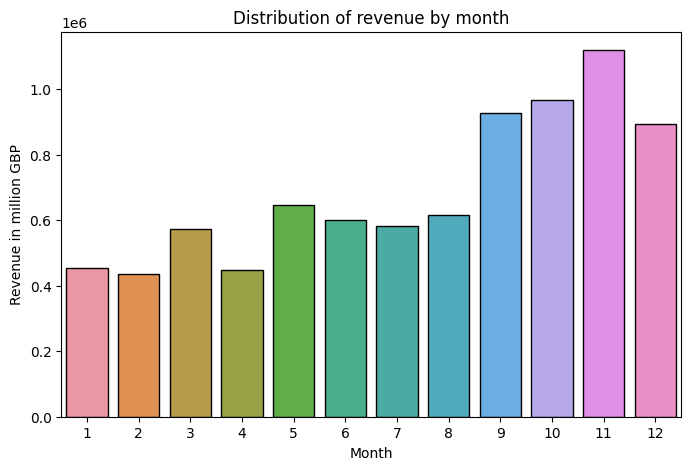

In [37]:
revenue_by_month = df.groupby('Month')['TotalPrice'].sum()
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x=revenue_by_month.index, y=revenue_by_month.values)
ax.set_title('Distribution of revenue by month')
ax.set_ylabel('Revenue in million GBP');

&rarr; Ноябрь - самый прибыльный месяц. Такой результат объясняется довольно просто: ноябрь предшествует декабрю, а в декабре отмечаются католическое Рождество и Новый год. Так как мы анализируем данные магазина подарков, то совсем не удивительно, что мы видим максимальный рост продаж в преддверии этих праздников.

Построим визуализацию количества заказов для каждого дня недели.

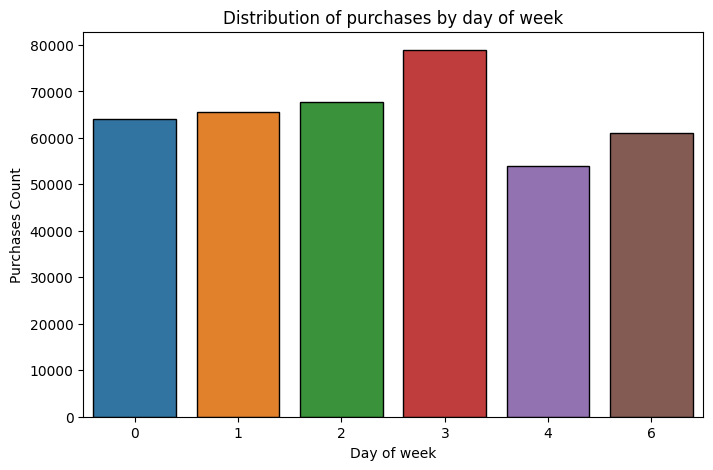

In [38]:
revenue_by_dayofweek = df.groupby('DayOfWeek')['InvoiceNo'].count()
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x=revenue_by_dayofweek.index, y=revenue_by_dayofweek.values)
ax.set_title('Distribution of purchases by day of week')
ax.set_xlabel('Day of week')
ax.set_ylabel('Purchases Count');

&rarr; Согласно данным, нет ни одной транзакции, совершённой в субботу, что довольно странно. Возможно, суббота является выходным днём и транзакции в этот день не совершаются, а может быть, это ошибка в данных.

Выделим дату из признака времени совершения транзакции. Сгруппируем данные по датам и часам совершения транзакции. Построим визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

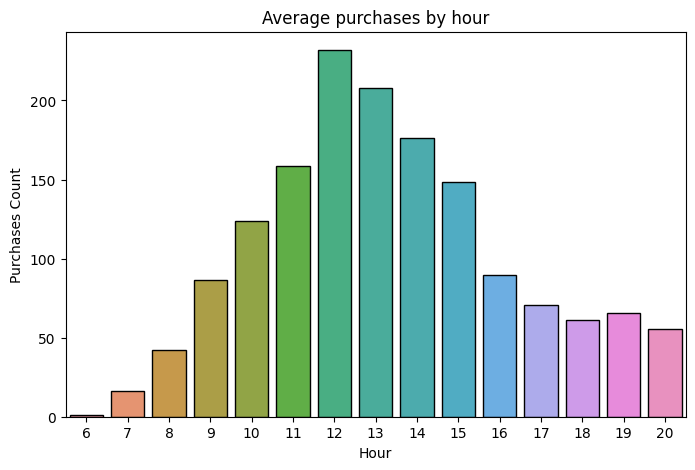

In [39]:
df['Date'] = df['InvoiceDate'].dt.date

purchases_by_day_hour = pd.DataFrame(df.groupby(['Date', 'Hour'])['InvoiceNo'].count()).reset_index()

table = purchases_by_day_hour.groupby('Hour')['InvoiceNo'].mean()
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x=table.index, y=table.values)
ax.set_title('Average purchases by hour')
ax.set_xlabel('Hour')
ax.set_ylabel('Purchases Count');

&rarr; Больше всего заказов совершается в дневное время, в интервале от 10 до 15 часов. С 21 часа до 6 утра (не включительно) заказы не поступают.

## 5. RFM-сегментация клиентов: часть 1

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Итак, приступим к созданию нашей RFM-таблицы. 

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

In [40]:
agg = {
    'InvoiceDate': lambda x: (pd.to_datetime('2011-12-10') - x.max()).days,
    'InvoiceNo': lambda x: len(x.unique()),
    'TotalPrice': lambda x: x.sum(),
}

rfm_table = df.groupby('CustomerID').agg(agg).rename(columns={
    'InvoiceDate': 'Recency', 
    'InvoiceNo': 'Frequency', 
    'TotalPrice': 'Monetary'
})
rfm_table.head(20)

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40
12352,36,7,1265.41
12353,204,1,89.00
12354,232,1,1079.40
12355,214,1,459.40


Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

In [41]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(rows=1, cols=3, subplot_titles=("Recency","Frequency", "Monetary"))

for i, box in enumerate(boxes): 
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_1.html')
fig.show()

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95% клиентов.


Удалите из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$ 

где $frequency_{0.95}$ и $monetary_{0.95}$ - квантили уровня 0.95 для соответствующих признаков. 

Данные о скольких клиентах у вас остались в RFM-таблице?


In [42]:
rfm_table_cleaned = rfm_table[(rfm_table['Frequency'] <= rfm_table['Frequency'].quantile(0.95)) & (rfm_table['Monetary'] <= rfm_table['Monetary'].quantile(0.95))]
print("Customers count:", rfm_table_cleaned.shape[0])

Customers count: 4044


Построим коробчатые диаграммы снова:

In [43]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(rows=1, cols=3, subplot_titles=("Recency", "Frequency", "Monetary"))

for i, box in enumerate(boxes): 
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_2.html')
fig.show()

Мы наконец добрались до этапа кластеризации. Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. Благо, у нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния. 

Построим визуализацию нашего трёхмерного пространства признаков:


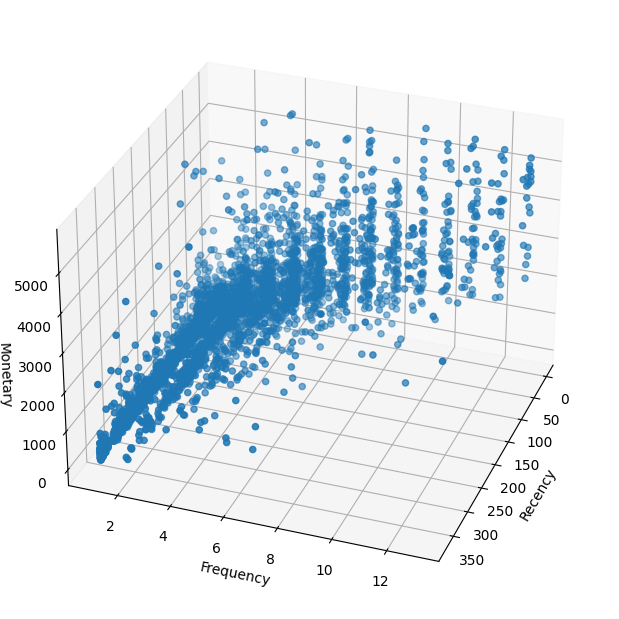

In [44]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30
# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');

Что здесь можно увидеть? На самом деле, ничего конкретного. Да, видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Давайте призовём на помощь методы снижения размерности.


Начнём с метода главных компонент (PCA). Нам известно, что для его стабильной работы данные необходимо стандартизировать/нормализовать. 

Давайте для удобства обернём эти шаги по предобработке данных в pipeline.

In [45]:
pipe = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()), 
    ('pca', decomposition.PCA(n_components=2))
])
rfm_table_processed = pipe.fit_transform(rfm_table_cleaned)

Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

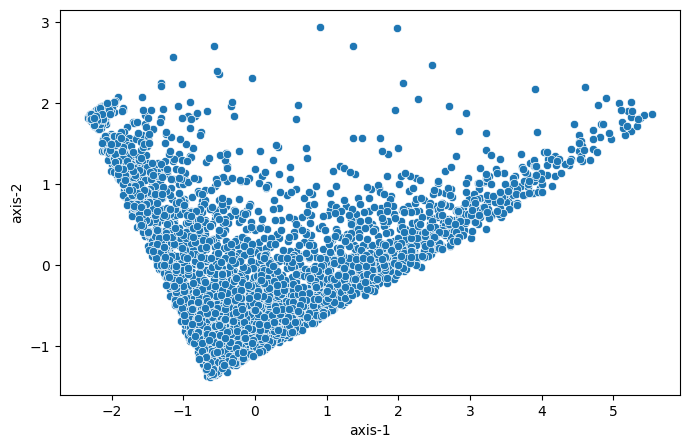

In [46]:
rfm_table_processed = pd.DataFrame({'axis-1': rfm_table_processed[:,0], 'axis-2': rfm_table_processed[:,1]})

fig = plt.figure(figsize=(8,5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Попробуем разделить это пространство главных компонент на сегменты при помощи метода k-means. Подберем оптимальное количество кластеров с помощью коэффициента силуэта.

,Cluster Number,Silhouette Score
0,3,0.524230
1,2,0.500296
2,4,0.497553


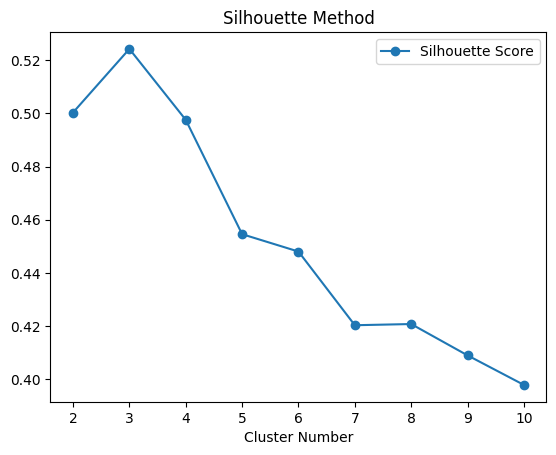

In [47]:
def get_silhouette(cluster_num, X):
    kmeans = cluster.KMeans(n_clusters=cluster_num, random_state=42)
    kmeans.fit(X)
    silhouette = metrics.silhouette_score(X, kmeans.labels_)
    return silhouette

clust_num = list(range(2,11))
silhouette = []
for n in clust_num:
    silhouette.append(get_silhouette(n, rfm_table_processed))

table = pd.DataFrame({'Cluster Number': clust_num, 'Silhouette Score': silhouette})
display(table.sort_values(by='Silhouette Score', ascending=False, ignore_index=True).head(3))

table.plot(
    kind='line',
    x='Cluster Number',
    y='Silhouette Score',
    marker='o',
    title='Silhouette Method'
);

Теперь возьмём EM-алгоритм. Подберем оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта.

,Cluster Number,Silhouette Score
0,3,0.436061
1,4,0.350103
2,2,0.342484


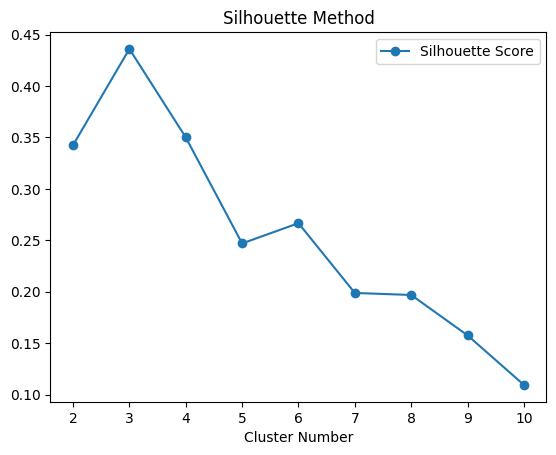

In [48]:
def get_silhouette(cluster_num, X):
    gm = mixture.GaussianMixture(n_components=cluster_num, random_state=42)
    label = gm.fit_predict(X)
    silhouette = metrics.silhouette_score(X, label)
    return silhouette

clust_num = list(range(2,11))
silhouette = []
for n in clust_num:
    silhouette.append(get_silhouette(n, rfm_table_processed))

table = pd.DataFrame({'Cluster Number': clust_num, 'Silhouette Score': silhouette})
display(table.sort_values(by='Silhouette Score', ascending=False, ignore_index=True).head(3))

table.plot(
    kind='line',
    x='Cluster Number',
    y='Silhouette Score',
    marker='o',
    title='Silhouette Method'
);

Давайте посмотрим на распределение кластеров.

Обучим модель с наилучшим коэффициентом силуэта (KMeans) с подобранным ранее количеством кластеров на декомпозированных данных.

In [49]:
kmeans = cluster.KMeans(n_clusters=3, random_state=42)
rfm_table_processed['labels'] = kmeans.fit_predict(rfm_table_processed)

Визуализируем результаты кластеризации:

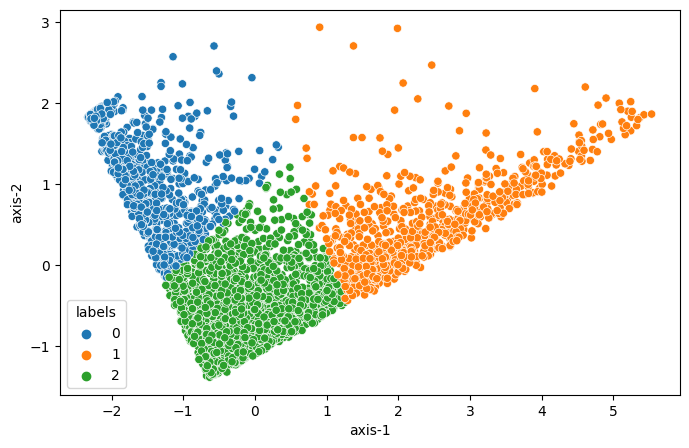

In [50]:
fig = plt.figure(figsize=(8,5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2',
    hue='labels',
    palette='tab10'
);

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов. Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков.

In [51]:
rfm_table_cleaned['Labels'] = kmeans.fit_predict(rfm_table_processed)
grouped_data = rfm_table_cleaned.groupby('Labels').mean()
round(grouped_data)

,Recency,Frequency,Monetary
Labels,,,
0,32.0,7.0,2658.0
1,253.0,1.0,386.0
2,51.0,2.0,660.0


### Полярная диаграмма
Сейчас мы познакомимся с одним из способов визуализации профиля кластеров — Radar Chart (полярная, или лепестковая, диаграмма). Это графическое представление значений нескольких эквивалентных категорий в форме «паутины».
Radar Chart очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 
Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На данной диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие к данному кластеру, в большей степени увлекаются музыкой (Music), а в меньшей степени — программированием (Programm).

В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции мы реализовали собственную функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в реализацию функции plot_cluster_profile().

In [52]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()
    

Теперь у нас есть удобный инструмент для анализа профиля кластеров. Давайте воспользуемся им.


Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 

In [53]:
plot_cluster_profile(grouped_data, 3)

* Кластер 0 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер 2 соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* Кластер 1 соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.

## 6. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, мы вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Давайте попробуем и посмотрим, что получится.

Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Давайте для удобства обернём шаги по предобработке данных в pipeline.

Найдем значение дивергенции Кульбака-Лейблера для обученного алгоритма t-SNE. Напомним, что дивергенция Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями.

In [54]:
rfm_table_cleaned

,Recency,Frequency,Monetary,Labels
CustomerID,,,,
12346,325,1,0.00,1
12347,2,7,4310.00,0
12348,75,4,1437.24,2
12349,18,1,1457.55,2
12350,310,1,294.40,1
...,...,...,...,...
18278,73,1,173.90,2
18280,277,1,180.60,1
18281,180,1,80.82,1


In [55]:
pipe = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()), 
    ('tsne', manifold.TSNE(n_components=2, perplexity=50, random_state=100))
])
rfm_table_processed = pipe.fit_transform(rfm_table_cleaned.drop('Labels', axis=1))
print("Kullback–Leibler divergence:", round(pipe['tsne'].kl_divergence_,2))

Kullback–Leibler divergence: 0.54


Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


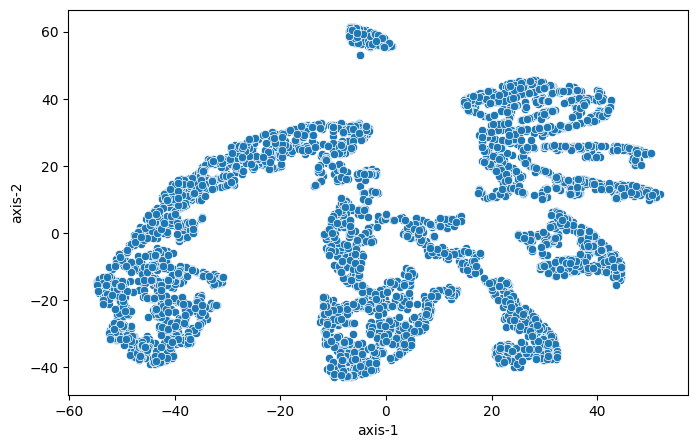

In [56]:
rfm_table_processed = pd.DataFrame({'axis-1': rfm_table_processed[:,0], 'axis-2': rfm_table_processed[:,1]})

fig = plt.figure(figsize=(8,5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


Попробуем воспользоваться методом k-means. 
Подберем оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно.

,Cluster Number,Silhouette Score
0,7,0.484495
1,8,0.482026
2,4,0.479278


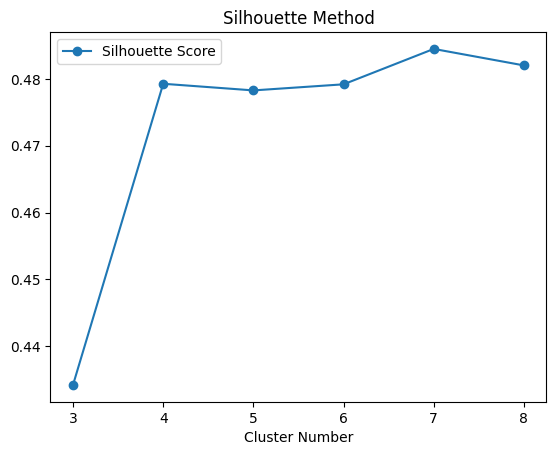

In [57]:
def get_silhouette(cluster_num, X):
    kmeans = cluster.KMeans(n_clusters=cluster_num, random_state=42)
    kmeans.fit(X)
    silhouette = metrics.silhouette_score(X, kmeans.labels_)
    return silhouette

clust_num = list(range(3,9))
silhouette = []
for n in clust_num:
    silhouette.append(get_silhouette(n, rfm_table_processed))

table = pd.DataFrame({'Cluster Number': clust_num, 'Silhouette Score': silhouette})
display(table.sort_values(by='Silhouette Score', ascending=False, ignore_index=True).head(3))

table.plot(
    kind='line',
    x='Cluster Number',
    y='Silhouette Score',
    marker='o',
    title='Silhouette Method'
);

Попробуем воспользоваться EM-алгоритом. Подберем оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно.

,Cluster Number,Silhouette Score
0,4,0.468827
1,6,0.457162
2,8,0.429173


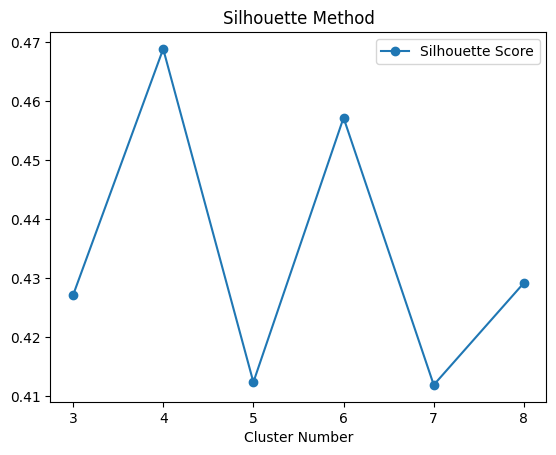

In [58]:
def get_silhouette(cluster_num, X):
    gm = mixture.GaussianMixture(n_components=cluster_num, random_state=42)
    label = gm.fit_predict(X)
    silhouette = metrics.silhouette_score(X, label)
    return silhouette

clust_num = list(range(3,9))
silhouette = []
for n in clust_num:
    silhouette.append(get_silhouette(n, rfm_table_processed))

table = pd.DataFrame({'Cluster Number': clust_num, 'Silhouette Score': silhouette})
display(table.sort_values(by='Silhouette Score', ascending=False, ignore_index=True).head(3))

table.plot(
    kind='line',
    x='Cluster Number',
    y='Silhouette Score',
    marker='o',
    title='Silhouette Method'
);

Наконец, попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering). Подберем оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 2 до 8 включительно.

,Cluster Number,Silhouette Score
0,8,0.479046
1,5,0.470394
2,6,0.469175


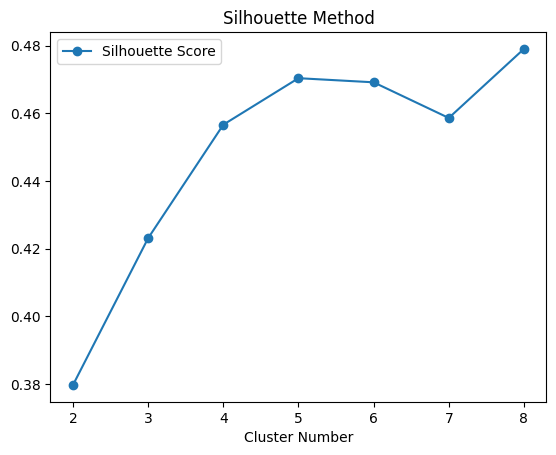

In [59]:
def get_silhouette(cluster_num, X):
    ac = cluster.AgglomerativeClustering(n_clusters=cluster_num)
    label = ac.fit_predict(X)
    silhouette = metrics.silhouette_score(X, label)
    return silhouette

clust_num = list(range(2,9))
silhouette = []
for n in clust_num:
    silhouette.append(get_silhouette(n, rfm_table_processed))

table = pd.DataFrame({'Cluster Number': clust_num, 'Silhouette Score': silhouette})
display(table.sort_values(by='Silhouette Score', ascending=False, ignore_index=True).head(3))

table.plot(
    kind='line',
    x='Cluster Number',
    y='Silhouette Score',
    marker='o',
    title='Silhouette Method'
);

Давайте посмотрим на распределение кластеров.

Обучим лучшую модель (KMeans) с подобранным ранее количеством кластеров на декомпозированных данных.

In [60]:
kmeans = cluster.KMeans(n_clusters=7, random_state=42)
rfm_table_processed['labels'] = kmeans.fit_predict(rfm_table_processed)

Визуализируем результаты кластеризации:

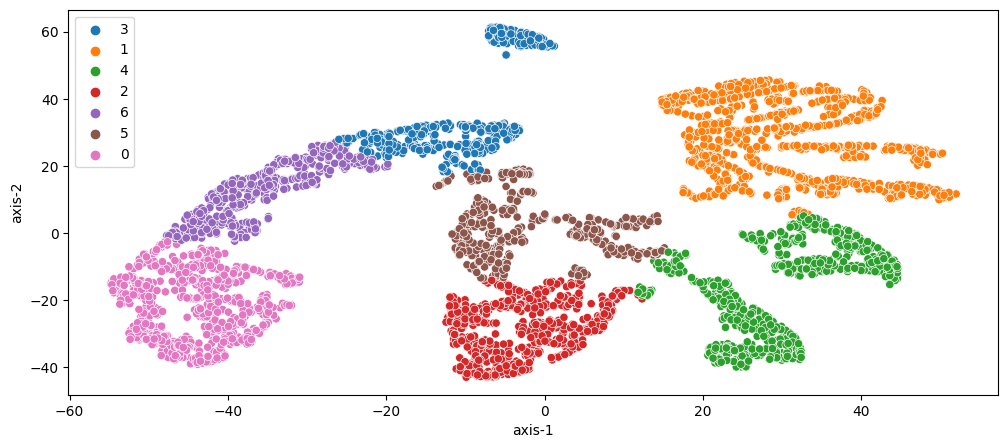

In [61]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', hue=kmeans.labels_.astype('str'));


Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов. 


Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков.

In [62]:
rfm_table_cleaned['Labels'] = kmeans.fit_predict(rfm_table_processed)
grouped_data = rfm_table_cleaned.groupby('Labels').mean()
round(grouped_data)

,Recency,Frequency,Monetary
Labels,,,
0,46.0,1.0,322.0
1,32.0,7.0,2417.0
2,40.0,2.0,614.0
3,313.0,1.0,261.0
4,40.0,3.0,995.0
5,196.0,2.0,670.0
6,181.0,1.0,273.0


Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

In [63]:
plot_cluster_profile(grouped_data, 7)

* Кластер 1 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер 4 соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер 2 соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер 5 соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер 0 соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* Кластер 6 соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер 3 соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.

## 7. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов. Но как сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку?

Вспомним, что мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Как же тогда производить кластеризацию для новых объектов, если мы не можем сжимать размерность для новых данных?

Давайте сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Давайте обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

Разделим исходные данные на тренировочную и тестовую выборки в соотношении 80/20.

In [64]:
X = rfm_table_cleaned.drop('Labels', axis=1)
y = rfm_table_cleaned['Labels']
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.8, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4044, 3) (4044,)
(3235, 3) (3235,)
(809, 3) (809,)


Дальше нам осталось только построить несколько моделей и выбрать из них лучшую. 
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут.

Поэтому давайте сразу возьмём тяжелую артиллерию — ансамблевые алгоритмы.

Начнём со случайного леса. С помощью GridSearchCV организуем перебор параметров случайного леса (RandomForestClassifier).

In [65]:
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

grid_search = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 13, 'n_estimators': 200}

С помощью лучших гиперпараметров сделаем предсказание для тестовой выборки и рассчитаем метрику accuracy.

In [66]:
rfc = ensemble.RandomForestClassifier(
    max_depth=13,
    criterion='gini',
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("Accuracy Score:", round(metrics.accuracy_score(y_test, y_pred), 3))

Accuracy Score: 0.985


Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

С помощью GridSearchCV организуем перебор параметров градиентного бустинга (GradientBoostingClassifier).

In [67]:
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

grid_search = model_selection.GridSearchCV(
    estimator=ensemble.GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}

С помощью лучших гиперпараметров сделаем предсказание для тестовой выборки и рассчитаем метрику accuracy. 

In [68]:
gbc = ensemble.GradientBoostingClassifier(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=200,
    random_state=42
)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print("Accuracy Score:", round(metrics.accuracy_score(y_test, y_pred), 3))

Accuracy Score: 0.983


**Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.**